In [4]:
import kagglehub
import os


/Users/madhumithas/Downloads/Projects/acne/mtcnn_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
dataset_path = kagglehub.dataset_download(
    "tiswan14/acne-dataset-image"
)

print("Dataset downloaded at:", dataset_path)

100%|██████████| 122M/122M [00:01<00:00, 64.3MB/s] 

Extracting files...


Dataset downloaded at: /Users/madhumithas/.cache/kagglehub/datasets/tiswan14/acne-dataset-image/versions/1


In [ ]:
import shutil
TARGET_DIR = "target_path"

# Create target folder
os.makedirs(TARGET_DIR, exist_ok=True)

# Move dataset
shutil.move(dataset_path, TARGET_DIR)

print("Dataset moved to:", TARGET_DIR)


Dataset moved to: /Users/madhumithas/Downloads/Projects/acne


In [ ]:
import os
DATASET_DIR = "dataset_path"
for split in ["train", "valid", "test"]:
    print(f"\n{split.upper()} FOLDERS:")
    print(os.listdir(os.path.join(DATASET_DIR, split)))



TRAIN FOLDERS:
['Whiteheads', '_train_classes.csv', 'Papules', 'Pustules', 'Cyst', 'Blackheads']

VALID FOLDERS:
['Whiteheads', '_valid_classes.csv', 'Papules', 'Pustules', 'Cyst', 'Blackheads']

TEST FOLDERS:
['_test_classes.csv', 'Whiteheads', 'Papules', 'Pustules', 'Cyst', 'Blackheads']


In [8]:
import pandas as pd
TRAIN_DIR = os.path.join(DATASET_DIR, "train")

class_counts = {}

for cls in os.listdir(TRAIN_DIR):
    cls_path = os.path.join(TRAIN_DIR, cls)
    if os.path.isdir(cls_path):
        class_counts[cls] = len(os.listdir(cls_path))

df_counts = pd.DataFrame.from_dict(
    class_counts, orient="index", columns=["Image_Count"]
)

print(df_counts)

            Image_Count
Whiteheads          193
Papules             621
Pustules            584
Cyst                645
Blackheads          735


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.35,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)

train_gen = train_datagen.flow_from_directory(
    directory=os.path.join(DATASET_DIR, "train"),
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)


Found 2778 images belonging to 5 classes.


In [11]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_directory(
    directory=os.path.join(DATASET_DIR, "valid"),
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)


Found 921 images belonging to 5 classes.


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    directory=os.path.join(DATASET_DIR, "test"),
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 918 images belonging to 5 classes.


In [13]:
print(train_gen.class_indices)


{'Blackheads': 0, 'Cyst': 1, 'Papules': 2, 'Pustules': 3, 'Whiteheads': 4}


In [14]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = train_gen.classes

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: np.float64(0.7559183673469387), 1: np.float64(0.8613953488372093), 2: np.float64(0.8946859903381642), 3: np.float64(0.9513698630136986), 4: np.float64(2.8787564766839377)}


In [22]:
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def build_model(model_name, input_shape=(224,224,3), num_classes=10, trainable=False):
    if model_name == "VGG16":
        base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "ResNet50":
        base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "MobileNetV2":
        base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
    elif model_name == "EfficientNetB0":
        base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Invalid model name")
    
    base_model.trainable = trainable  # freeze or unfreeze
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    output = Dense(num_classes, activation="softmax")(x)
    
    model = Model(base_model.input, output)
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model


In [23]:
models_to_train = ["VGG16", "ResNet50", "MobileNetV2", "EfficientNetB0"]
histories = {}

for name in models_to_train:
    print(f"Training {name}...")
    model = build_model(name, input_shape=(224,224,3), num_classes=train_gen.num_classes)
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        class_weight=class_weights
    )
    histories[name] = history


Training VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.2923 - loss: 1.5536 - val_accuracy: 0.3474 - val_loss: 1.4588
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 437s 5s/step - accuracy: 0.3499 - loss: 1.4292 - val_accuracy: 0.3442 - val_loss: 1.4373
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 441s 5s/step - accuracy: 0.3754 - loss: 1.3772 - val_accuracy: 0.3833 - val_loss: 1.3780
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 526s 6s/step - accuracy: 0.4017 - loss: 1.3191 - val_accuracy: 0.3876 - val_loss: 1.3440
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 470s 5s/step - accuracy: 0.4273 - loss: 1.2732 - val_accuracy: 0.4419 - val_loss: 1.2717
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1303s 15s/step - accuracy: 0.4262 - loss: 1.2600 - val_accuracy: 0.4615 - val_loss: 1.2630
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 441s 5s/step - accuracy: 0.4352 - loss: 1.2416 - val_accuracy: 0.3887 - val_loss: 1.3461
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 55

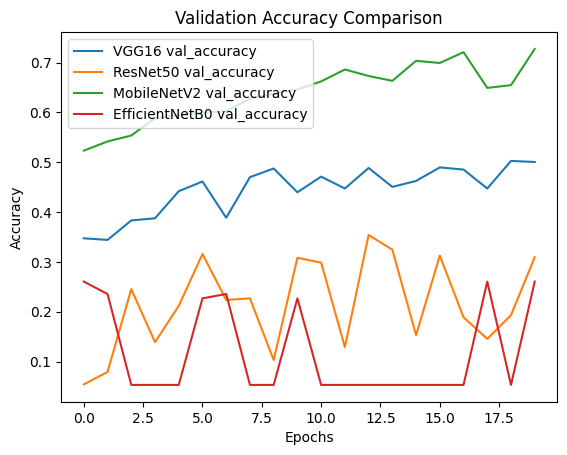

In [24]:
import matplotlib.pyplot as plt

for name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=f'{name} val_accuracy')
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [25]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 1️⃣ Compute class weights
labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

# 2️⃣ Build MobileNetV2 model
def build_mobilenet(input_shape=(224,224,3), num_classes=10, trainable=False):
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = trainable  # freeze or unfreeze for fine-tuning
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation="relu")(x)
    output = Dense(num_classes, activation="softmax")(x)
    
    model = Model(base_model.input, output)
    return model

# 3️⃣ Phase 1: Train only top layers
model = build_mobilenet(input_shape=(224,224,3), num_classes=train_gen.num_classes, trainable=False)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('mobilenet_top_layers.h5', save_best_only=True)
]

history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

# 4️⃣ Phase 2: Fine-tune deeper layers
# Unfreeze last 40 layers (example)


Class weights: {0: np.float64(0.7559183673469387), 1: np.float64(0.8613953488372093), 2: np.float64(0.8946859903381642), 3: np.float64(0.9513698630136986), 4: np.float64(2.8787564766839377)}
Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.3699 - loss: 1.5276

87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 259ms/step - accuracy: 0.4240 - loss: 1.3241 - val_accuracy: 0.5081 - val_loss: 1.1446
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5413 - loss: 1.0260

87/87 ━━━━━━━━━━━━━━━━━━━━ 22s 254ms/step - accuracy: 0.5353 - loss: 1.0495 - val_accuracy: 0.5288 - val_loss: 1.0958
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 261ms/step - accuracy: 0.5526 - loss: 0.9831 - val_accuracy: 0.5342 - val_loss: 1.1005
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5845 - loss: 0.9413

87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step - accuracy: 0.5911 - loss: 0.9266 - val_accuracy: 0.5874 - val_loss: 0.9903
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5982 - loss: 0.8866

87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 285ms/step - accuracy: 0.6030 - loss: 0.8842 - val_accuracy: 0.5950 - val_loss: 0.9742
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6324 - loss: 0.8021

87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 293ms/step - accuracy: 0.6343 - loss: 0.8227 - val_accuracy: 0.6113 - val_loss: 0.9350
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6302 - loss: 0.7987

87/87 ━━━━━━━━━━━━━━━━━━━━ 829s 10s/step - accuracy: 0.6357 - loss: 0.7966 - val_accuracy: 0.6211 - val_loss: 0.8941
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6756 - loss: 0.7413

87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step - accuracy: 0.6602 - loss: 0.7649 - val_accuracy: 0.6243 - val_loss: 0.8933
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6399 - loss: 0.7738

87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 281ms/step - accuracy: 0.6515 - loss: 0.7685 - val_accuracy: 0.6287 - val_loss: 0.8589
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.6835 - loss: 0.7384

87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 281ms/step - accuracy: 0.6764 - loss: 0.7461 - val_accuracy: 0.6656 - val_loss: 0.8261
Epoch 1/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.5236 - loss: 1.1977

87/87 ━━━━━━━━━━━━━━━━━━━━ 33s 340ms/step - accuracy: 0.5666 - loss: 1.0067 - val_accuracy: 0.5071 - val_loss: 1.4950
Epoch 2/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 31s 355ms/step - accuracy: 0.6760 - loss: 0.7315 - val_accuracy: 0.4495 - val_loss: 2.1792
Epoch 3/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 31s 354ms/step - accuracy: 0.7228 - loss: 0.6391 - val_accuracy: 0.5103 - val_loss: 1.7305
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 31s 356ms/step - accuracy: 0.7563 - loss: 0.5573 - val_accuracy: 0.4788 - val_loss: 2.1057
Epoch 5/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 65s 749ms/step - accuracy: 0.7937 - loss: 0.5024 - val_accuracy: 0.4701 - val_loss: 2.6217
Epoch 6/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 28s 320ms/step - accuracy: 0.8074 - loss: 0.4576 - val_accuracy: 0.4495 - val_loss: 2.4448


In [39]:
model.save("acne_classifier.h5")


In [24]:
from tensorflow.keras.models import load_model

# Load your trained model
model_path = "acne_classifier.h5"
model = load_model(model_path)

print("Model loaded successfully!")


Model loaded successfully!


In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = val_gen.classes
y_pred = np.argmax(model.predict(val_gen), axis=1)

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step
              precision    recall  f1-score   support

           0       0.92      0.76      0.83       240
           1       0.69      0.81      0.74       206
           2       0.65      0.78      0.71       209
           3       0.78      0.69      0.73       217
           4       0.93      0.80      0.86        49

    accuracy                           0.76       921
   macro avg       0.79      0.77      0.77       921
weighted avg       0.78      0.76      0.76       921

[[183  24  19  13   1]
 [  2 166  33   5   0]
 [  4  18 162  23   2]
 [  7  30  31 149   0]
 [  3   3   4   0  39]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


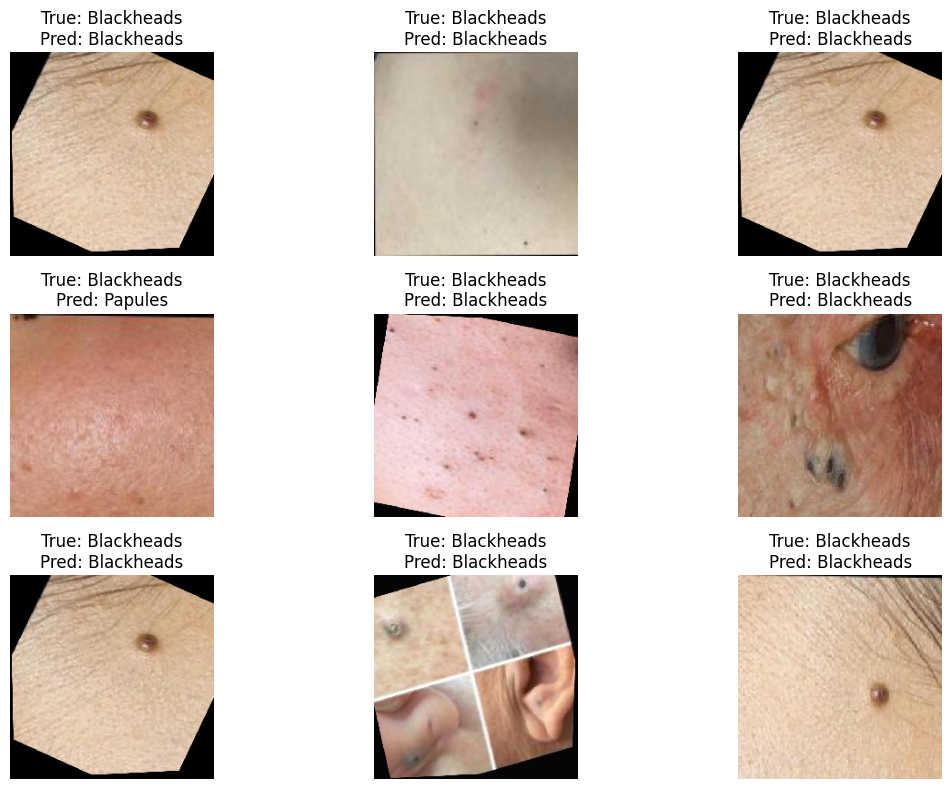

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import random

class_names = list(val_gen.class_indices.keys())

# Get a batch
images, labels = next(val_gen)
preds = model.predict(images)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(labels, axis=1)

# Plot few samples
plt.figure(figsize=(12,8))
for i in range(9):
    idx = random.randint(0, len(images)-1)
    plt.subplot(3,3,i+1)
    plt.imshow(images[idx])
    plt.axis("off")
    plt.title(
        f"True: {class_names[true_classes[idx]]}\n"
        f"Pred: {class_names[pred_classes[idx]]}"
    )
plt.tight_layout()
plt.show()
